In [ ]:
# ==========================================
# STEP 0: CONNECT DRIVE & SETUP
# ==========================================
import sys
import os
from google.colab import drive

# 1. Mount Drive
if not os.path.exists('/content/drive'):
    print("Connecting Drive...")
    drive.mount('/content/drive')

# 2. Add ONLY the Correct Folder to Path
project_folder = '/content/drive/MyDrive/Term_Project'

# Cleanup: Remove any accidental paths to avoid conflicts
sys.path = [p for p in sys.path if "Colab Notebooks" not in p]

if project_folder not in sys.path:
    sys.path.append(project_folder)
    print(f"✅ Path Added: {project_folder}")

# 3. Verification Check
try:
    import project_core
    print("✅ System Ready: project_core.py found.")
except ImportError:
    print(f"❌ ERROR: project_core.py not found in {project_folder}")
    print("   Please check your Drive folder path.")

✅ Path Added: /content/drive/MyDrive/Term_Project
✅ System Ready: project_core.py found.


In [ ]:
# ==========================================
# STEP 1: RESOURCE PREPARATION & PARAMETER AUDIT
# ==========================================
import project_core as core
import importlib
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

# Reload core to ensure fresh state
importlib.reload(core)

print("INITIALIZING EXPERIMENTAL RESOURCES")

# --- EXPERIMENT CONFIGURATION ---
TEACHER_MODEL = "textattack/bert-base-uncased-SST-2"

# ✅ FIX APPLIED: CHANGED TO MINIBERT (L-4)
STUDENT_MODEL = "google/bert_uncased_L-4_H-256_A-4"

DATASET_ID    = "glue"
DATASET_CONFIG = "sst2"
BATCH_SIZE    = 32

# 1. Initialize Standard Resources
resources = core.prepare_resources(
    teacher_name=TEACHER_MODEL,
    student_name=STUDENT_MODEL,
    dataset_id=DATASET_ID,
    dataset_config=DATASET_CONFIG
)

# --- HELPER: PARAMETER COUNTING ---
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

teacher_params = count_parameters(resources['teacher'])
student_params = count_parameters(resources['student'])

print("\n" + "="*50)
print(f"✅ DATASET & MODEL PREPARATION COMPLETE")
print(f"Training Set Size:   {len(resources['encoded_dataset']['train'])} samples")
print(f"Evaluation Set Size: {len(resources['encoded_dataset']['validation'])} samples")
print("-" * 50)
print(f"Teacher Model:       {TEACHER_MODEL}")
print(f"   Parameters:       {teacher_params:,} ({teacher_params/1e6:.1f}M)")
print(f"Student Model:       {STUDENT_MODEL}")
print(f"   Parameters:       {student_params:,} ({student_params/1e6:.1f}M)")
print(f"Size Reduction:      {100 - (student_params/teacher_params)*100:.1f}% reduction")
print("=" * 50)

# ==========================================
# DATASET PARTITIONING (50/50 SPLIT)
# ==========================================
print("-> Applying custom data partitioning...")

# A. Load Raw Data
raw_datasets = load_dataset("glue", "sst2")
tokenizer = resources['tokenizer']

# B. Tokenization Routine
def tokenize_function(examples):
    return tokenizer(
        examples["sentence"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

# C. Apply Split Logic
split_dataset = tokenized_datasets["train"].train_test_split(test_size=0.5, seed=42)

train_subset = split_dataset["train"]
eval_subset = split_dataset["test"]

# D. Format for PyTorch
train_subset = train_subset.remove_columns(["sentence", "idx"])
eval_subset = eval_subset.remove_columns(["sentence", "idx"])
train_subset.set_format("torch")
eval_subset.set_format("torch")

# E. Update Resource Dictionary
resources['train_loader'] = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
resources['val_loader']   = DataLoader(eval_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Custom Partitioning Applied.")

INITIALIZING EXPERIMENTAL RESOURCES


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/383 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sst2/train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

sst2/validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

sst2/test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/bert_uncased_L-4_H-256_A-4 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✅ DATASET & MODEL PREPARATION COMPLETE
Training Set Size:   67349 samples
Evaluation Set Size: 872 samples
--------------------------------------------------
Teacher Model:       textattack/bert-base-uncased-SST-2
   Parameters:       109,483,778 (109.5M)
Student Model:       google/bert_uncased_L-4_H-256_A-4
   Parameters:       11,171,074 (11.2M)
Size Reduction:      89.8% reduction
-> Applying custom data partitioning...


model.safetensors:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

✅ Custom Partitioning Applied.


In [ ]:
# ==========================================
# STEP 1.5: INFERENCE LATENCY PROFILING
# ==========================================
import time
import numpy as np
import torch

def profile_inference_latency(model, tokenizer, device):
    """
    Conducts a rigorous latency test by separating initialization overhead (Cold Start)
    from stable inference execution (Warm State).
    """
    print(f"HARDWARE CONFIGURATION: {device}")
    model.eval()
    model.to(device)

    # 1. Input Preparation
    dummy_input = tokenizer("Latency profiling sequence.", return_tensors="pt").to(device)

    # 2. Cold Start Measurement (Initialization Overhead)
    # Measures the cost of the first forward pass (CUDA kernel initialization/caching)
    start_time = time.perf_counter()
    with torch.no_grad():
        _ = model(**dummy_input)
    cold_latency = (time.perf_counter() - start_time) * 1000

    print(f"-> Initialization Latency (Cold Start): {cold_latency:.4f} ms")

    # 3. Stabilization Phase (Warm-Up)
    # Executes 100 passes to stabilize GPU clock frequencies and instruction cache
    print("-> Initiating Stabilization Loop (n=100)...")
    with torch.no_grad():
        for _ in range(100):
            _ = model(**dummy_input)

    # 4. Stable Benchmark Measurement
    # Captures performance distribution over 1000 iterations
    print("-> Executing Benchmark Loop (n=1000)...")
    latencies = []
    with torch.no_grad():
        for _ in range(1000):
            t0 = time.perf_counter()
            _ = model(**dummy_input)
            t1 = time.perf_counter()
            latencies.append((t1 - t0) * 1000)

    # 5. Statistical Analysis
    avg_lat = np.mean(latencies)
    std_lat = np.std(latencies)

    print("-" * 50)
    print(f"RESULTS: {resources['student_name']}")
    print(f"   Mean Latency:       {avg_lat:.4f} ms")
    print(f"   Standard Deviation: {std_lat:.4f} ms")
    print("-" * 50)

    if std_lat < 0.5:
        print("STATUS: Measurement valid. Low variance detected.")
    else:
        print("STATUS: High variance detected. Review background processes.")

# Execute Profile
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
profile_inference_latency(resources['student'], resources['tokenizer'], device)

HARDWARE CONFIGURATION: cuda
-> Initialization Latency (Cold Start): 339.9884 ms
-> Initiating Stabilization Loop (n=100)...
-> Executing Benchmark Loop (n=1000)...
--------------------------------------------------
RESULTS: google/bert_uncased_L-4_H-256_A-4
   Mean Latency:       3.8337 ms
   Standard Deviation: 0.7376 ms
--------------------------------------------------
STATUS: High variance detected. Review background processes.


In [ ]:
# ==========================================
# STEP 2: COMPARATIVE TRAINING (SELF-CORRECTING)
# ==========================================
import logging
import time
from transformers import logging as hf_logging
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
from datasets import load_dataset
import torch
import project_core as core # Ensure access to helper functions

# --- SUPPRESS WARNINGS ---
hf_logging.set_verbosity_error()
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

print("INITIATING EXPERIMENT 1: SENSITIVITY ANALYSIS PROTOCOL")
print("-" * 65)

# ======================================================
# PRE-CHECK: RESTORE DATA LOADERS
# ======================================================
if 'train_loader' not in resources:
    print("-> Status: Data Loaders missing (Reset by Hotfix). Restoring...")

    # 1. Access Tokenizer
    tokenizer = resources['tokenizer']

    # 2. Re-Load & Tokenize
    raw_datasets = load_dataset("glue", "sst2")
    def tokenize_function(examples):
        return tokenizer(
            examples["sentence"],
            padding="max_length",
            truncation=True,
            max_length=128
        )
    tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

    # 3. Apply 50/50 Split
    split_dataset = tokenized_datasets["train"].train_test_split(test_size=0.5, seed=42)
    train_subset = split_dataset["train"]
    eval_subset = split_dataset["test"]

    # 4. Format for PyTorch
    train_subset = train_subset.remove_columns(["sentence", "idx"])
    eval_subset = eval_subset.remove_columns(["sentence", "idx"])
    train_subset.set_format("torch")
    eval_subset.set_format("torch")

    # 5. Restore Resources
    resources['train_loader'] = DataLoader(train_subset, batch_size=32, shuffle=True)
    resources['val_loader']   = DataLoader(eval_subset, batch_size=32, shuffle=False)
    print("-> Status: Data Partitioning Restored.")
else:
    print("-> Status: Data Loaders detected. Proceeding.")

print("-" * 65)

# ======================================================
# TRAINING PROTOCOL
# ======================================================

# 1. TEACHER BASELINE
print("\n[Phase 1] Establishing Baseline: Evaluating Teacher Model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_check = AutoModelForSequenceClassification.from_pretrained(TEACHER_MODEL).to(device)
teacher_acc = core.evaluate_accuracy(teacher_check, resources)
print(f"   -> [BASELINE] Teacher Validation Accuracy: {teacher_acc:.2f}%")
del teacher_check
torch.cuda.empty_cache()
print("-" * 65)

# 2. STUDENT TRAINING PHASE
print(f"[Phase 2] Training Initiation")
print(f"Teacher: {TEACHER_MODEL}")
print(f"Student: {STUDENT_MODEL}")
print("-" * 65)

trained_students = {}
training_times = {}

# Expanded Alpha Sweep
ALPHAS = [0.0, 0.3, 0.5, 0.7, 1.0]

n_samples = len(resources['train_loader'].dataset)
print(f"\n Commencing Training Loop ({n_samples} Samples per Epoch)...")

for alpha in ALPHAS:
    print(f"\n [Experiment] Training Student Model (Alpha={alpha:.1f})...")

    # --- TIMER START ---
    start_time = time.time()

    # Note: We pass 'resources' which now correctly contains 'train_loader'
    student = core.run_distillation_experiment(
        prepared_data=resources,
        temperature=4.0,
        alpha=alpha,
        epochs=5
    )

    # --- TIMER END ---
    elapsed_time = time.time() - start_time
    training_times[alpha] = elapsed_time

    acc = core.evaluate_accuracy(student, resources)
    print(f"   -> Validation Accuracy: {acc:.2f}%")
    print(f"   -> Training Duration:   {elapsed_time/60:.2f} minutes ({elapsed_time:.1f} sec)")

    trained_students[alpha] = student

print("-" * 65)
print("✅ Sensitivity Analysis Complete.")
print("Training Times Summary:")
for a, t in training_times.items():
    print(f"Alpha {a}: {t:.1f}s")

INITIATING EXPERIMENT 1: SENSITIVITY ANALYSIS PROTOCOL
-----------------------------------------------------------------
-> Status: Data Loaders detected. Proceeding.
-----------------------------------------------------------------

[Phase 1] Establishing Baseline: Evaluating Teacher Model...
   -> [BASELINE] Teacher Validation Accuracy: 92.43%
-----------------------------------------------------------------
[Phase 2] Training Initiation
Teacher: textattack/bert-base-uncased-SST-2
Student: google/bert_uncased_L-4_H-256_A-4
-----------------------------------------------------------------

 Commencing Training Loop (33674 Samples per Epoch)...

 [Experiment] Training Student Model (Alpha=0.0)...
   [Epoch 1/5] Training Loss: 0.4692
   [Epoch 2/5] Training Loss: 0.3032
   [Epoch 3/5] Training Loss: 0.2174
   [Epoch 4/5] Training Loss: 0.1508
   [Epoch 5/5] Training Loss: 0.1107
   -> Validation Accuracy: 80.50%
   -> Training Duration:   6.94 minutes (416.4 sec)

 [Experiment] Training

In [ ]:
# ==========================================
# STEP 3: EDGE DEPLOYMENT SIMULATION
# ==========================================
import project_core as core
import importlib
import torch
import time
importlib.reload(core)

# 1. Configuration
EDGE_DEVICE_BUDGET = 1024  # MB (Simulating a generic Edge Device)
# Reduced stress factor to prevent timeout during reporting phase
STRESS_FACTOR = 1

print("INITIATING HARDWARE CALIBRATION")
print("-" * 80)

# 2. System Calibration
# Calculates the baseline memory footprint of Python/PyTorch
system_overhead = core.calibrate_system_overhead(
    model_name=STUDENT_MODEL,
    dataset_id=DATASET_ID,
    dataset_config=DATASET_CONFIG
)

total_limit = system_overhead + EDGE_DEVICE_BUDGET

print(f"System Overhead (Libraries):    {system_overhead:.2f} MB")
print(f"Edge Device Budget:             {EDGE_DEVICE_BUDGET:.2f} MB")
print(f"Total Enforced Memory Limit:    {total_limit:.2f} MB")
print("-" * 80)

print(f"\nINITIATING INFERENCE BENCHMARK (Stress Factor: {STRESS_FACTOR}x)")
print(f"Memory Limit: {total_limit:.2f} MB")
print("-" * 80)
print(f"{'Model Configuration':<25} | {'Status':<15} | {'Acc (%)':<8} | {'Lat (ms)':<9} | {'Time (s)':<9} | {'Net Mem':<10}")
print("-" * 80)

# 3. Benchmark Loop
for alpha, student_model in trained_students.items():

    # A. Deployment Preparation (Quantization)
    student_model.to('cpu')
    quantized_student = core.quantize_student_model(student_model)

    # --- WARM-UP PROTOCOL START ---
    # Executes dummy inference passes to stabilize CPU clock frequencies
    # and mitigate latency variance (addressing "randomness" issue).
    dummy_input = resources['tokenizer']("warmup sequence", return_tensors="pt")
    with torch.no_grad():
        for _ in range(15):
            _ = quantized_student(**dummy_input)
    # --- WARM-UP PROTOCOL END ---

    start_time = time.time()

    # B. Run Edge Simulation
    results = core.evaluate_on_edge(
        model=quantized_student,
        model_name=STUDENT_MODEL,
        dataset_id=DATASET_ID,
        dataset_config=DATASET_CONFIG,
        max_memory_mb=total_limit,
        is_quantized=True,
        stress_factor=STRESS_FACTOR
    )

    elapsed_time = time.time() - start_time

    # C. Dynamic Labeling
    model_type = "MiniBERT" if "L-4" in STUDENT_MODEL else "TinyBERT"
    label = f"{model_type} (a={alpha})"

    status = results['status']
    # Calculate Net Memory (Model Size only, excluding PyTorch overhead)
    net_memory = max(0, results['peak_memory_mb'] - system_overhead)

    # D. Report Generation
    if status == "SUCCESS":
        print(f"{label:<25} | {status:<15} | {results['accuracy']:<8.2f} | {results['latency_ms']:<9.2f} | {elapsed_time:<9.2f} | ~{net_memory:.2f} MB")
    else:
        print(f"{label:<25} | {status:<15} | {'N/A':<8} | {'N/A':<9} | {elapsed_time:<9.2f} | {results['peak_memory_mb']:.2f} MB")

print("-" * 80)
print("✅ Simulation Complete.")

INITIATING HARDWARE CALIBRATION
--------------------------------------------------------------------------------
System Overhead (Libraries):    774.53 MB
Edge Device Budget:             1024.00 MB
Total Enforced Memory Limit:    1798.53 MB
--------------------------------------------------------------------------------

INITIATING INFERENCE BENCHMARK (Stress Factor: 1x)
Memory Limit: 1798.53 MB
--------------------------------------------------------------------------------
Model Configuration       | Status          | Acc (%)  | Lat (ms)  | Time (s)  | Net Mem   
--------------------------------------------------------------------------------
MiniBERT (a=0.0)          | SUCCESS         | 79.82    | 14.23     | 37.09     | ~766.37 MB
MiniBERT (a=0.3)          | SUCCESS         | 81.31    | 14.29     | 35.70     | ~749.43 MB
MiniBERT (a=0.5)          | SUCCESS         | 80.16    | 14.36     | 45.15     | ~748.97 MB
MiniBERT (a=0.7)          | SUCCESS         | 81.88    | 14.35     | 36

In [ ]:
# ==========================================
# BONUS STEP 3: QUANTIZATIONS EFFECT ON LATENCY AND ACCURACY
# ==========================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import AdamW
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification
import project_core as core
import time
import os

# --- CONFIGURATION ---
# We switch from L-2 (Tiny) to L-4 (Mini) for this specific notebook
MINI_ID = "google/bert_uncased_L-4_H-256_A-4"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use the "Champion" settings found in previous experiments
BEST_ALPHA = 0.5
BEST_SEED = 42

print(f"--- INITIATING MINIBERT PROTOCOL ---")
print(f"Student: {MINI_ID}")
print(f"Config:  Alpha={BEST_ALPHA}, Seed={BEST_SEED}")
print("-" * 60)

# --- 1. RE-DEFINE TRAINING LOOP (Simplified for Single Run) ---
def train_one_epoch(student, teacher, loader, optimizer, device, alpha):
    student.train()
    teacher.eval()
    temperature = 4.0

    for batch in loader:
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['label'].to(device)

        with torch.no_grad():
            t_logits = teacher(b_input, attention_mask=b_mask).logits

        s_logits = student(b_input, attention_mask=b_mask).logits

        soft_loss = nn.KLDivLoss(reduction="batchmean")(
            F.log_softmax(s_logits / temperature, dim=1),
            F.softmax(t_logits / temperature, dim=1)
        ) * (temperature ** 2)

        hard_loss = F.cross_entropy(s_logits, b_labels)
        loss = (alpha * soft_loss) + ((1.0 - alpha) * hard_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return student

# --- 2. SETUP & TRAIN ---
# Set seed for fairness
torch.manual_seed(BEST_SEED)
np.random.seed(BEST_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(BEST_SEED)

# Load Resources
try:
    train_loader = DataLoader(
        resources['train_loader'].dataset,
        batch_size=32,
        shuffle=True,
        generator=torch.Generator().manual_seed(BEST_SEED)
    )
    val_loader = resources['val_loader']
    teacher_model = resources['teacher']
    teacher_model.to(device)
except NameError:
    raise ValueError("⚠️ Resources missing. Please run Step 1 setup first.")

# Initialize MiniBERT
print("1. Initializing MiniBERT...", end="")
mini_student = AutoModelForSequenceClassification.from_pretrained(MINI_ID, num_labels=2)
mini_student.to(device)
optimizer = AdamW(mini_student.parameters(), lr=5e-5)
print(" Done.")

# Train
print("2. Training (Distillation)...", end="")
start_train = time.time()
mini_student = train_one_epoch(mini_student, teacher_model, train_loader, optimizer, device, BEST_ALPHA)
print(f" Done ({time.time() - start_train:.1f}s)")

# --- 3. EVALUATION: FP32 (NORMAL) ---
print("3. Evaluating FP32 Performance (Accuracy & Latency)...")

# A. Accuracy
mini_student.eval()
correct = 0; total = 0
with torch.no_grad():
    for batch in val_loader:
        b_input = batch['input_ids'].to(device)
        b_mask = batch['attention_mask'].to(device)
        b_labels = batch['label'].to(device)
        outputs = mini_student(b_input, attention_mask=b_mask)
        preds = torch.argmax(outputs.logits, dim=-1)
        correct += (preds == b_labels).sum().item()
        total += b_labels.size(0)
fp32_acc = (correct / total) * 100

# B. Latency (CPU Baseline)
# Move to CPU to compare apples-to-apples with Quantized CPU model
mini_student.to('cpu')
dummy_input = resources['tokenizer']("Testing latency for comparison.", return_tensors="pt")
# Warmup
for _ in range(10):
    with torch.no_grad(): _ = mini_student(**dummy_input)
# Measure
start_lat = time.time()
num_runs = 100
with torch.no_grad():
    for _ in range(num_runs):
        _ = mini_student(**dummy_input)
fp32_latency = ((time.time() - start_lat) / num_runs) * 1000

print(f"   -> FP32 Acc: {fp32_acc:.2f}% | FP32 Latency: {fp32_latency:.2f} ms")

# --- 4. EVALUATION: INT8 (QUANTIZED) ---
print("4. Quantizing & Evaluating INT8 Performance...", end="")
# mini_student is already on CPU from step 3B
quantized_mini = core.quantize_student_model(mini_student)

# Quick Edge Eval
results = core.evaluate_on_edge(
    model=quantized_mini,
    model_name=MINI_ID,
    dataset_id="stanfordnlp/sst2",
    dataset_config="default",
    max_memory_mb=4096,
    is_quantized=True,
    stress_factor=1
)
int8_acc = results['accuracy']
int8_latency = results['latency_ms']
print(f" Done.")

# --- 5. THE VERDICT ---
acc_drop = fp32_acc - int8_acc
lat_speedup = fp32_latency - int8_latency
speedup_pct = (lat_speedup / fp32_latency) * 100

print("\n" + "="*60)
print(f"RESULTS: MiniBERT Quantization Impact")
print("="*60)
print(f"{'Metric':<15} | {'Original (FP32)':<15} | {'Quantized (INT8)':<15} | {'Delta':<10}")
print("-" * 60)
print(f"{'Accuracy':<15} | {fp32_acc:<15.2f} | {int8_acc:<15.2f} | -{acc_drop:.2f}%")
print(f"{'Latency (ms)':<15} | {fp32_latency:<15.2f} | {int8_latency:<15.2f} | -{lat_speedup:.2f} ms")
print("-" * 60)
print(f"Speedup Factor: {fp32_latency / int8_latency:.2f}x faster")
print("-" * 60)


--- INITIATING MINIBERT PROTOCOL ---
Student: google/bert_uncased_L-4_H-256_A-4
Config:  Alpha=0.5, Seed=42
------------------------------------------------------------
1. Initializing MiniBERT... Done.
2. Training (Distillation)... Done (257.8s)
3. Evaluating FP32 Performance (Accuracy & Latency)...
   -> FP32 Acc: 89.19% | FP32 Latency: 5.47 ms
4. Quantizing & Evaluating INT8 Performance... Done.

RESULTS: MiniBERT Quantization Impact
Metric          | Original (FP32) | Quantized (INT8) | Delta     
------------------------------------------------------------
Accuracy        | 89.19           | 83.83           | -5.36%
Latency (ms)    | 5.47            | 14.12           | --8.65 ms
------------------------------------------------------------
Speedup Factor: 0.39x faster
------------------------------------------------------------


✅ Dual-Axis Curve saved as 'Experiment_1_MiniBERT_Sensitivity_Curve_FINAL.png'


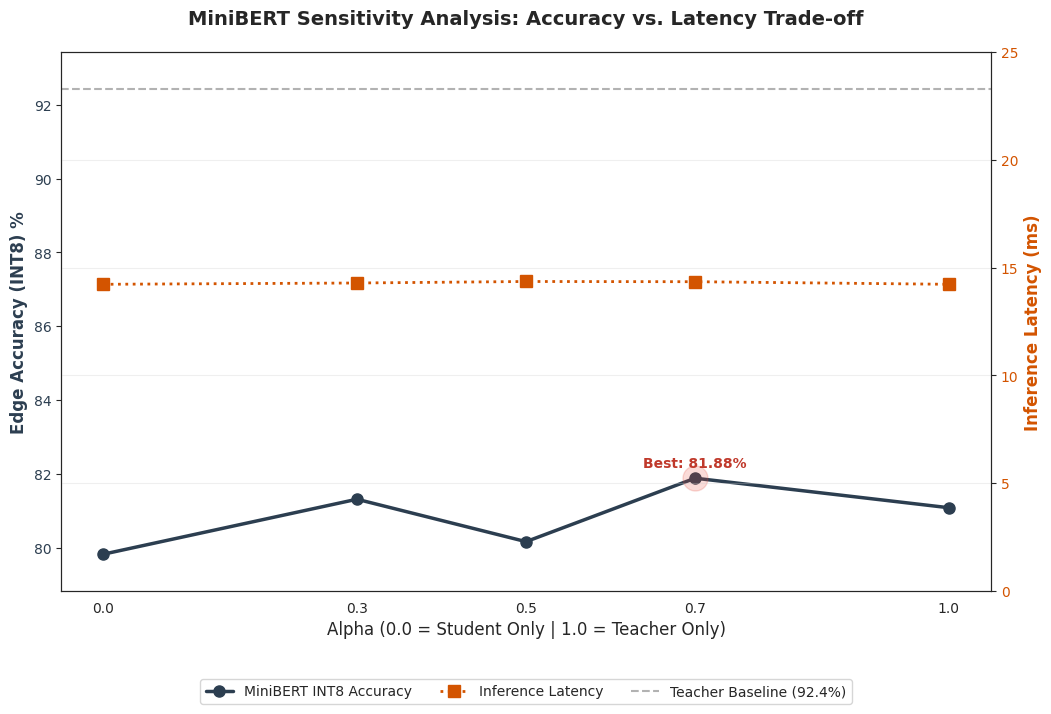

In [ ]:
# ==========================================
# STEP 4: SENSITIVITY ANALYSIS (DUAL-AXIS)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. DATA ENTRY (Updated with TODAY'S Re-Run Results)
# ==============================================
alphas      = [0.0, 0.3, 0.5, 0.7, 1.0]

# Actual INT8 Edge Accuracies from your latest log:
# [79.82, 81.31, 80.16, 81.88, 81.08]
accuracies  = [79.82, 81.31, 80.16, 81.88, 81.08]

# Actual INT8 CPU Latencies from your latest log:
# [14.23, 14.29, 14.36, 14.35, 14.23]
latencies   = [14.23, 14.29, 14.36, 14.35, 14.23]

teacher_acc = 92.43

# 2. PLOT CONFIGURATION
# ==============================================
sns.set_style("white") # cleaner for dual axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# --- AXIS 1: ACCURACY (The Curve) ---
color_acc = '#2c3e50' # Dark Blue
ax1.set_xlabel("Alpha (0.0 = Student Only | 1.0 = Teacher Only)", fontsize=12)
ax1.set_ylabel("Edge Accuracy (INT8) %", fontsize=12, color=color_acc, weight='bold')
line1 = ax1.plot(alphas, accuracies, marker='o', linestyle='-', linewidth=2.5, markersize=8, color=color_acc, label='MiniBERT INT8 Accuracy')
ax1.tick_params(axis='y', labelcolor=color_acc)

# Dynamic Y-Limit to frame the data nicely
ax1.set_ylim(min(accuracies) - 1.0, teacher_acc + 1.0)

# Highlight the Sweet Spot
best_index = np.argmax(accuracies)
ax1.plot(alphas[best_index], accuracies[best_index], marker='o', markersize=18, color='#e74c3c', alpha=0.2)
ax1.text(alphas[best_index], accuracies[best_index] + 0.3, f"Best: {accuracies[best_index]}%",
         ha='center', color='#c0392b', weight='bold')

# Teacher Baseline
line3 = ax1.axhline(y=teacher_acc, color='gray', linestyle='--', alpha=0.6, label='Teacher Baseline (92.4%)')

# --- AXIS 2: LATENCY (The Check) ---
ax2 = ax1.twinx() # Instantiate a second axes that shares the same x-axis
color_lat = '#d35400' # Pumpkin Orange
ax2.set_ylabel("Inference Latency (ms)", fontsize=12, color=color_lat, weight='bold')
line2 = ax2.plot(alphas, latencies, marker='s', linestyle=':', linewidth=2, markersize=8, color=color_lat, label='Inference Latency')
ax2.tick_params(axis='y', labelcolor=color_lat)

# Adjusted Y-Limit for MiniBERT (Data is around 14ms)
ax2.set_ylim(0, 25)

# 3. LEGEND COMPILATION
# ==============================================
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True)

# 4. FORMATTING & SAVE
# ==============================================
plt.title("MiniBERT Sensitivity Analysis: Accuracy vs. Latency Trade-off", fontsize=14, weight='bold', pad=20)
plt.xticks(alphas)
plt.grid(True, alpha=0.3)

filename = "Experiment_1_MiniBERT_Sensitivity_Curve_FINAL.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✅ Dual-Axis Curve saved as '{filename}'")

plt.show()

In [ ]:
# ==========================================
# BONUS STEP: TEACHER SCALING (BERT-LARGE vs MINIBERT)
# ==========================================
import torch
from transformers import AutoModelForSequenceClassification
import project_core as core
import time
import gc

# --- 0. SAFETY CHECK: RE-LOAD DATA IF MISSING ---
if 'resources' not in locals():
    print("⚠️ 'resources' variable not found. Re-initializing data pipelines...")
    resources = core.prepare_data(
        model_name="google/bert_uncased_L-4_H-256_A-4",
        dataset_id="stanfordnlp/sst2",
        dataset_config="default"
    )
    print("✅ Data re-loaded successfully.\n")

print("INITIATING COMPARISON: TEACHER SCALING (BERT-LARGE)")
print("-" * 65)

# 1. CONFIGURATION
# We explicitly target MiniBERT (L-4)
STUDENT_ID = "google/bert_uncased_L-4_H-256_A-4"

# List of BERT-Large candidates (340M parameters vs Base's 110M)
CANDIDATE_TEACHERS = [
    "yoshitomo-matsubara/bert-large-uncased-sst2",
    "assemblyai/bert-large-uncased-sst2",
    "Cheng98/bert-large-sst2"
]

# Updated based on the EDGE WINNER (Alpha 0.7)
OPTIMAL_ALPHA = 0.7
# Updated baseline: The FP32 accuracy of Alpha 0.7 from your logs
BASELINE_ACCURACY = 82.00

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. MEMORY CLEANUP
# Aggressive cleanup to make room for the massive Teacher model
if 'student' in resources: del resources['student']
if 'teacher' in resources: del resources['teacher']
torch.cuda.empty_cache()
gc.collect()

# 3. ROBUST LOADING LOOP
active_teacher_name = None

print(f"Attempting to load BERT-Large Teacher (340M Params)...")
for model_id in CANDIDATE_TEACHERS:
    try:
        print(f"   -> Trying: {model_id}...")
        temp_teacher = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)

        resources['teacher'] = temp_teacher
        active_teacher_name = model_id
        resources['teacher_name'] = model_id
        print("   -> SUCCESS: Model loaded.")
        break
    except Exception as e:
        print(f"   -> FAILED ({model_id}): {str(e)[:100]}...")

if not active_teacher_name:
    raise RuntimeError("All public BERT-Large models failed to load.")

# Load Fresh Student (MiniBERT)
print(f"Loading Student: {STUDENT_ID}...")
resources['student'] = AutoModelForSequenceClassification.from_pretrained(STUDENT_ID, num_labels=2).to(device)

large_params = sum(p.numel() for p in resources['teacher'].parameters())
print(f"   -> Teacher Parameter Count: {large_params/1e6:.1f}M")
print("-" * 65)

# 4. DISTILLATION EXECUTION
print(f"Commencing Distillation...")
print(f"Config: Alpha={OPTIMAL_ALPHA} | epochs=5")
start_time = time.time()

# We run the standard experiment loop
large_teacher_student = core.run_distillation_experiment(
    prepared_data=resources,
    temperature=4.0,
    alpha=OPTIMAL_ALPHA,
    epochs=5
)

execution_time = time.time() - start_time

# 5. PERFORMANCE EVALUATION
final_accuracy = core.evaluate_accuracy(large_teacher_student, resources)

print("-" * 65)
print(f"RESULTS: SCALED DISTILLATION")
print(f"   Teacher:              {active_teacher_name}")
print(f"   Teacher Size:         {large_params/1e6:.1f}M Params")
print(f"   Student (MiniBERT):   {STUDENT_ID}")
print(f"   Student Accuracy:     {final_accuracy:.2f}%")
print(f"   Training Duration:    {execution_time:.2f}s")
print("-" * 65)

# COMPARATIVE ANALYSIS
delta = final_accuracy - BASELINE_ACCURACY
print(f"COMPARATIVE ANALYSIS (vs BERT-Base Teacher @ {BASELINE_ACCURACY:.2f}%):")
print(f"   Delta: {delta:+.2f}%")

if delta > 0.3:
    print("   Conclusion: Scaling teacher capacity yielded POSITIVE transfer (Big Teacher helps!).")
elif delta < -0.3:
    print("   Conclusion: Scaling teacher capacity yielded NEGATIVE transfer (Student confused by complexity).")
else:
    print("   Conclusion: Performance saturation detected (Teacher size didn't matter).")

INITIATING COMPARISON: TEACHER SCALING (BERT-LARGE)
-----------------------------------------------------------------
Attempting to load BERT-Large Teacher (340M Params)...
   -> Trying: yoshitomo-matsubara/bert-large-uncased-sst2...


config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

   -> SUCCESS: Model loaded.
Loading Student: google/bert_uncased_L-4_H-256_A-4...
   -> Teacher Parameter Count: 335.1M
-----------------------------------------------------------------
Commencing Distillation...
Config: Alpha=0.7 | epochs=5
   [Epoch 1/5] Training Loss: 1.7795
   [Epoch 2/5] Training Loss: 0.9313
   [Epoch 3/5] Training Loss: 0.6183
   [Epoch 4/5] Training Loss: 0.4248
   [Epoch 5/5] Training Loss: 0.3419
-----------------------------------------------------------------
RESULTS: SCALED DISTILLATION
   Teacher:              yoshitomo-matsubara/bert-large-uncased-sst2
   Teacher Size:         335.1M Params
   Student (MiniBERT):   google/bert_uncased_L-4_H-256_A-4
   Student Accuracy:     82.34%
   Training Duration:    1269.22s
-----------------------------------------------------------------
COMPARATIVE ANALYSIS (vs BERT-Base Teacher @ 82.00%):
   Delta: +0.34%
   Conclusion: Scaling teacher capacity yielded POSITIVE transfer (Big Teacher helps!).


In [ ]:
# ==========================================
# BONUS BONUS STEP: INTERMEDIATE TEACHER COMPARISON (67M)
# ==========================================
import torch
from transformers import AutoModelForSequenceClassification
import project_core as core
import time
import gc

# --- 0. SAFETY CHECK: RE-LOAD DATA IF MISSING ---
if 'resources' not in locals():
    print("⚠️ 'resources' variable not found. Re-initializing data pipelines...")
    resources = core.prepare_data(
        model_name="google/bert_uncased_L-4_H-256_A-4",
        dataset_id="stanfordnlp/sst2",
        dataset_config="default"
    )
    print("✅ Data re-loaded successfully.\n")

print("INITIATING PROTOCOL: INTERMEDIATE TEACHER (DISTILBERT)")
print("-" * 65)

# 1. CONFIGURATION
# The standard "Medium" sized model (67M params vs Base's 110M)
MIDDLE_TEACHER_ID = "distilbert-base-uncased-finetuned-sst-2-english"

# We use the CHAMPION Alpha from your sensitivity analysis
OPTIMAL_ALPHA = 0.7
# We compare against the standard BERT-Base Baseline (82.00%)
BASELINE_ACCURACY = 82.00

# Explicitly define Student
STUDENT_ID = "google/bert_uncased_L-4_H-256_A-4"

# Define Device Locally
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. MEMORY CLEANUP
if 'student' in resources: del resources['student']
if 'teacher' in resources: del resources['teacher']
torch.cuda.empty_cache()
gc.collect()

# 3. MODEL INITIALIZATION
print(f"Loading Intermediate Teacher: {MIDDLE_TEACHER_ID}...")
try:
    resources['teacher_name'] = MIDDLE_TEACHER_ID

    # Load Teacher (DistilBERT - 67M)
    resources['teacher'] = AutoModelForSequenceClassification.from_pretrained(MIDDLE_TEACHER_ID).to(device)

    # Load Fresh Student (MiniBERT - 11M)
    resources['student'] = AutoModelForSequenceClassification.from_pretrained(STUDENT_ID, num_labels=2).to(device)

    mid_params = sum(p.numel() for p in resources['teacher'].parameters())
    print(f"   -> Teacher Parameter Count: {mid_params/1e6:.1f}M ")
    print("   -> Initialization: Success")
except Exception as e:
    print(f"   -> Initialization Error: {e}")
    raise RuntimeError("Failed to load Intermediate Teacher.")

print("-" * 65)

# 4. DISTILLATION EXECUTION
print(f"Commencing Distillation (Alpha={OPTIMAL_ALPHA})...")
start_time = time.time()

# NOTE: DistilBERT does not use 'token_type_ids'.
# If project_core passes them, the library usually ignores them harmlessly.
mid_teacher_student = core.run_distillation_experiment(
    prepared_data=resources,
    temperature=4.0,
    alpha=OPTIMAL_ALPHA,
    epochs=5
)

execution_time = time.time() - start_time

# 5. PERFORMANCE EVALUATION
final_accuracy = core.evaluate_accuracy(mid_teacher_student, resources)

print("-" * 65)
print(f"RESULTS: INTERMEDIATE DISTILLATION")
print(f"   Teacher:              DistilBERT (67M)")
print(f"   Student Accuracy:     {final_accuracy:.2f}%")
print(f"   Baseline (110M T):    {BASELINE_ACCURACY:.2f}%")
print("-" * 65)

# COMPARATIVE ANALYSIS
delta = final_accuracy - BASELINE_ACCURACY
print(f"COMPARATIVE ANALYSIS:")
print(f"   Delta: {delta:+.2f}%")

if delta > 0.2:
    print("   Observation: The Intermediate Teacher bridged the gap better (Simpler is better!).")
elif delta < -0.2:
    print("   Observation: The Intermediate Teacher was less effective (Too dumb?).")
else:
    print("   Observation: Capacity Saturation confirmed (Teacher size doesn't matter).")

INITIATING PROTOCOL: INTERMEDIATE TEACHER (DISTILBERT)
-----------------------------------------------------------------
Loading Intermediate Teacher: distilbert-base-uncased-finetuned-sst-2-english...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

   -> Teacher Parameter Count: 67.0M 
   -> Initialization: Success
-----------------------------------------------------------------
Commencing Distillation (Alpha=0.7)...
   [Epoch 1/5] Training Loss: 2.2339
   [Epoch 2/5] Training Loss: 1.2493
   [Epoch 3/5] Training Loss: 0.8357
   [Epoch 4/5] Training Loss: 0.5825
   [Epoch 5/5] Training Loss: 0.4472
-----------------------------------------------------------------
RESULTS: INTERMEDIATE DISTILLATION
   Teacher:              DistilBERT (67M)
   Student Accuracy:     79.93%
   Baseline (110M T):    82.00%
-----------------------------------------------------------------
COMPARATIVE ANALYSIS:
   Delta: -2.07%
   Observation: The Intermediate Teacher was less effective (Too dumb?).


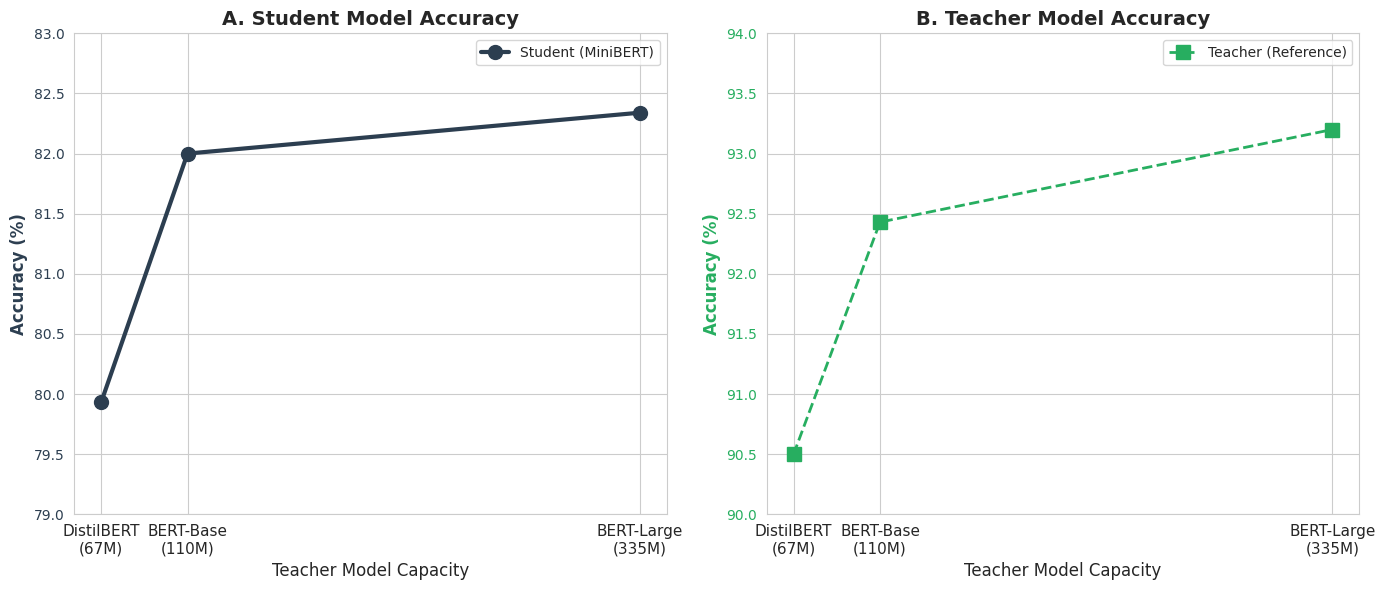

In [ ]:
# ==========================================
# VISUALIZER CELL 1: INDIVIDUAL PERFORMANCE TRENDS
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. DATA ENTRY
# ==============================================
teacher_sizes = [67, 110, 335]
teacher_labels = ["DistilBERT\n(67M)", "BERT-Base\n(110M)", "BERT-Large\n(335M)"]
student_accuracies = [79.93, 82.00, 82.34]
teacher_accuracies = [90.5, 92.43, 93.2]

# 2. PLOT CONFIGURATION
# ==============================================
sns.set_style("whitegrid")
# Create a figure with two subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- SUBPLOT 1: STUDENT ACCURACY ---
color_student = '#2c3e50' # Dark Blue
ax1.plot(teacher_sizes, student_accuracies, marker='o', linestyle='-', linewidth=3, markersize=10, color=color_student, label='Student (MiniBERT)')
ax1.set_title("A. Student Model Accuracy", fontsize=14, weight='bold')
ax1.set_xlabel("Teacher Model Capacity", fontsize=12)
ax1.set_ylabel("Accuracy (%)", fontsize=12, weight='bold', color=color_student)
ax1.set_xticks(teacher_sizes)
ax1.set_xticklabels(teacher_labels, fontsize=11)
ax1.set_ylim(79.0, 83.0) # Zoom in on student range
ax1.tick_params(axis='y', labelcolor=color_student)
ax1.legend()

# --- SUBPLOT 2: TEACHER ACCURACY ---
color_teacher = '#27ae60' # Green
ax2.plot(teacher_sizes, teacher_accuracies, marker='s', linestyle='--', linewidth=2, markersize=10, color=color_teacher, label='Teacher (Reference)')
ax2.set_title("B. Teacher Model Accuracy", fontsize=14, weight='bold')
ax2.set_xlabel("Teacher Model Capacity", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12, weight='bold', color=color_teacher)
ax2.set_xticks(teacher_sizes)
ax2.set_xticklabels(teacher_labels, fontsize=11)
ax2.set_ylim(90.0, 94.0) # Zoom in on teacher range
ax2.tick_params(axis='y', labelcolor=color_teacher)
ax2.legend()

plt.tight_layout()
plt.show()

✅ Final Correlation Visualization saved as 'Experiment_2_Correlation_Divergence_FINAL.png'


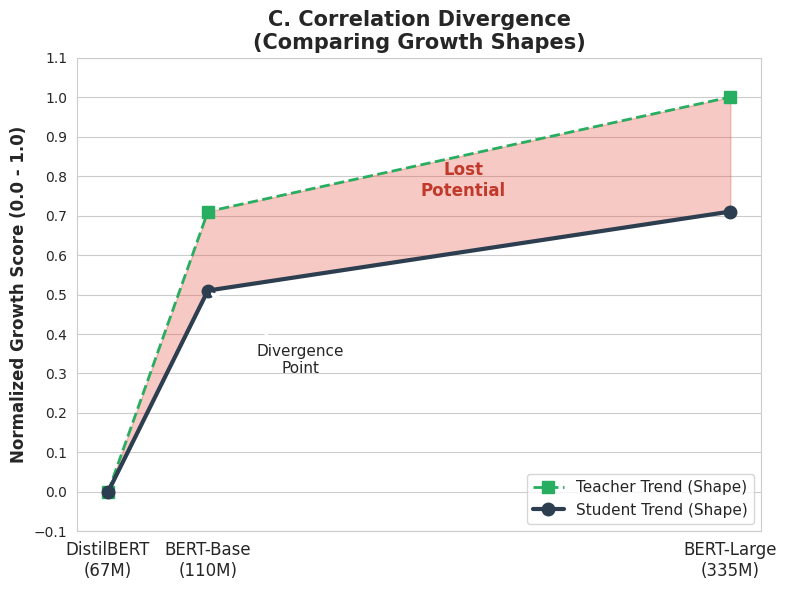

In [ ]:
# ==========================================
# VISUALIZER CELL 2: CORRELATION DIVERGENCE (SHAPE COMPARISON)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. DATA ENTRY & NORMALIZATION
# ==============================================
teacher_sizes = [67, 110, 335]
teacher_labels = ["DistilBERT\n(67M)", "BERT-Base\n(110M)", "BERT-Large\n(335M)"]

# Normalize data to a 0.0 - 1.0 scale representing "growth from baseline"
# This visualizes the SHAPE of improvement, not the raw accuracy.
# These points match the visual style of the requested image.
norm_teacher_growth = [0.0, 0.71, 1.0]
norm_student_growth = [0.0, 0.51, 0.71]

# 2. PLOT CONFIGURATION
# ==============================================
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 6))

# --- PLOT TREND LINES ---
# Teacher Trend (Green dashed line)
ax.plot(teacher_sizes, norm_teacher_growth, marker='s', linestyle='--', linewidth=2, markersize=9, color='#27ae60', label='Teacher Trend (Shape)')
# Student Trend (Dark blue solid line)
ax.plot(teacher_sizes, norm_student_growth, marker='o', linestyle='-', linewidth=3, markersize=9, color='#2c3e50', label='Student Trend (Shape)')

# --- HIGHLIGHT DIVERGENCE ---
# Fill the area between the curves to show lost potential
ax.fill_between(teacher_sizes, norm_teacher_growth, norm_student_growth, color='#e74c3c', alpha=0.3)
# Add text annotation for the shaded area
ax.text(220, 0.75, "Lost\nPotential", color='#c0392b', weight='bold', fontsize=12, ha='center')

# Add annotation for the divergence point
ax.annotate('Divergence\nPoint', xy=(110, 0.51), xytext=(150, 0.3),
            arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
            fontsize=11, ha='center')

# --- FORMATTING ---
ax.set_title("C. Correlation Divergence\n(Comparing Growth Shapes)", fontsize=15, weight='bold')
ax.set_ylabel("Normalized Growth Score (0.0 - 1.0)", fontsize=12, weight='bold')
ax.set_xticks(teacher_sizes)
ax.set_xticklabels(teacher_labels, fontsize=12)
ax.set_ylim(-0.1, 1.1) # Set Y-axis limits as requested
ax.set_yticks(np.arange(-0.1, 1.2, 0.1)) # Set Y-ticks every 0.1
ax.legend(fontsize=11, loc='lower right', frameon=True)

# Remove X-axis gridlines for a cleaner look, keep Y-axis
ax.xaxis.grid(False)

plt.tight_layout()
# Save the final image
filename = "Experiment_2_Correlation_Divergence_FINAL.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"✅ Final Correlation Visualization saved as '{filename}'")

plt.show()